In [62]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler


In [57]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_75236/2375169706.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


In [58]:

df["date"] = pd.to_datetime(df["date"])
df["unit_sales"] = df["unit_sales"].fillna(0)
df['unit_sales'] = df['unit_sales'].clip(lower=0)

In [59]:
df["date"].unique()

<DatetimeArray>
['2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00', '2013-01-11 00:00:00', '2013-01-12 00:00:00',
 '2013-01-13 00:00:00', '2013-01-14 00:00:00', '2013-01-15 00:00:00',
 '2013-01-16 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1674, dtype: datetime64[ns]

In [60]:
df.describe()

,date,store_nbr,item_nbr,unit_sales
count,167304,167304.000000,1.673040e+05,167304.000000
mean,2015-04-27 04:57:39.015923200,39.099155,4.964799e+05,77.878761
min,2013-01-07 00:00:00,3.000000,1.147900e+05,0.000000
25%,2014-03-03 00:00:00,44.000000,3.143840e+05,29.423250
50%,2015-04-28 00:00:00,47.000000,5.023310e+05,53.000000
75%,2016-06-21 00:00:00,49.000000,5.828640e+05,91.321499
max,2017-08-15 00:00:00,51.000000,1.047679e+06,4635.000000
std,NaN,16.962276,2.374778e+05,88.393265


In [17]:
store_med = (
            df.groupby(["store_nbr","date"])["unit_sales"]
                .median()
                .unstack(fill_value=0)
        )
store_med = store_med.T
store_med.reset_index(inplace=True)

In [18]:
store_med.to_excel(
    "../output/data/train_store_mded_top_10_store_10_item.xlsx",
    index=False
)

In [ ]:
item_med = (
            df.groupby(["item_nbr","date"])["unit_sales"]
                .median()
                .unstack(fill_value=0)
        )
item_med =  item_med.T
item_med.reset_index(inplace=True)

In [20]:
item_med.to_excel(
    "../output/data/train_item_median_top_10_store_10_item.xlsx",
    index=False
)

In [61]:
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,store_item
0,2013-01-07,48,502331,70.000000,NaN,48_502331
1,2013-01-07,48,567623,25.000000,NaN,48_567623
2,2013-01-07,48,581078,16.000000,NaN,48_581078
3,2013-01-07,48,582864,63.675999,NaN,48_582864
4,2013-01-07,49,314384,34.000000,NaN,49_314384


,date,store_nbr,item_nbr,unit_sales,onpromotion,store_item
62,2013-01-07,3,1047679,578.0,NaN,3_1047679
164,2013-01-08,3,1047679,340.0,NaN,3_1047679
263,2013-01-09,3,1047679,398.0,NaN,3_1047679
362,2013-01-10,3,1047679,520.0,NaN,3_1047679
463,2013-01-11,3,1047679,543.0,NaN,3_1047679
563,2013-01-12,3,1047679,910.0,NaN,3_1047679
663,2013-01-13,3,1047679,784.0,NaN,3_1047679
773,2013-01-14,3,1047679,467.0,NaN,3_1047679
864,2013-01-15,3,1047679,460.0,NaN,3_1047679
962,2013-01-16,3,1047679,272.0,NaN,3_1047679


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def plot_unit_sales_with_arima(df, sid):
    # 1) Filter & prepare
    df_sid = df[df["store_item"] == sid].copy()
    df_sid["date"] = pd.to_datetime(df_sid["date"])
    df_sid = df_sid.set_index("date").sort_index()
    
    # 2) Plot raw unit_sales
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df_sid.index, df_sid["unit_sales"], label="Observed", alpha=0.7)
    
    # 3) Fit ARIMA(0,1,1)
    #    Note: enforce_stationary=False to allow I(1), disp=False to suppress output
    model = ARIMA(df_sid["unit_sales"], order=(1,1,1))
    res   = model.fit()
    
    # 4) Get in‑sample one‑step predictions
    #    'dynamic=False' gives the one‑step forecast at each time point
    fitted = res.predict(start=df_sid.index[0],
                         end=df_sid.index[-1],
                         dynamic=False)
    
    # 5) Overlay fitted series
    ax.plot(fitted.index, fitted, 
            label="ARIMA(0,1,1) fitted", 
            color="C1", linewidth=1.5)
    
    # 6) Legend, labels, title
    ax.set_title(f"{sid} — unit_sales with ARIMA(0,1,1) fit",fontsize=24, fontweight="bold")
    ax.set_xlabel("Date", fontsize=24, fontweight="bold")
    ax.set_ylabel("Unit Sales",fontsize=24, fontweight="bold")
    ax.legend(loc="upper left", fontsize=12)
    fig.tight_layout(pad=3.0)
    plt.savefig(f"../output/figures/{sid}_sale_arima.tiff", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    return res



/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


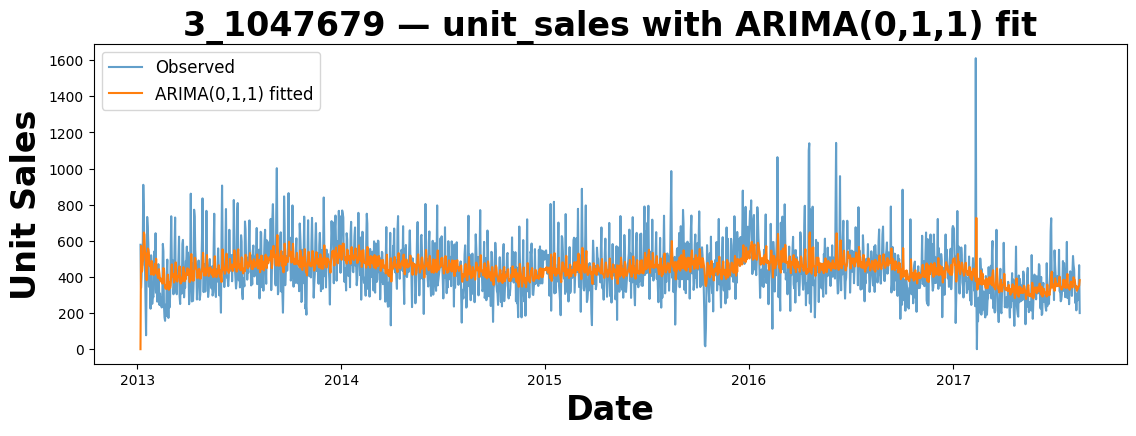

In [75]:
res = plot_unit_sales_with_arima(df, sid="3_1047679")


In [ ]:
# 1) Turn the summary into Summary2, which exposes tables as DataFrames
sum_table = res.summary()
# 2) Grab the two tables
tbl_info = sum_table.tables[0]   # model fit stats
tbl_coef = sum_table.tables[1]   # coefficients, std err, z, p‑value, CIs

# 3) Convert each table to a DataFrame
model_info_df = pd.DataFrame(tbl_info.data[1:], columns=tbl_info.data[0])
coefs_df      = pd.DataFrame(tbl_coef.data[1:],  columns=tbl_coef.data[0])

# 4) Write them out to Excel
with pd.ExcelWriter("../output/data/3_1047679_arima_summary.xlsx") as writer:
    model_info_df.to_excel(writer, sheet_name="Model_Info", index=False)
    coefs_df     .to_excel(writer, sheet_name="Coefficients", index=False)

print("Wrote arima_summary.xlsx with two sheets: Model_Info & Coefficients")

Wrote arima_summary.xlsx with two sheets: Model_Info & Coefficients


In [21]:
def generate_nonoverlap_window_features(
    df: pd.DataFrame,
    window_size: int = 5
) -> pd.DataFrame:
    """
    Splits the dates in train_df into non-overlapping windows of length `window_size`,
    then for each (store_nbr, item_nbr) within each window computes:
      - total sales on each day
      - median sales per store on each day
      - median sales per item on each day

    Returns a DataFrame with columns:
      - id = '{store}_{item}_{window_start:%Y-%m-%d}'
      - sales_day_1 ... sales_day_{window_size}
      - store_med_day_1 ... store_med_day_{window_size}
      - item_med_day_1 ... item_med_day_{window_size}'
    """
    # 1) Ensure datetime
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # 2) Build non-overlapping windows
    unique_dates = df["date"].sort_values().unique()
    chunked_windows = [
        unique_dates[i : i + window_size]
        for i in range(0, len(unique_dates), window_size)
        if len(unique_dates[i : i + window_size]) == window_size
    ]

    records = []
    for window_dates in chunked_windows:
        window_start = pd.to_datetime(window_dates[0])
        window_str   = window_start.strftime("%Y-%m-%d")

        # subset to this window
        w_df = df[df["date"].isin(window_dates)]

        # precompute medians & sums
        store_med = (
            w_df.groupby(["store_nbr","date"])["unit_sales"]
                .median()
                .unstack(fill_value=0)
        )
        item_med = (
            w_df.groupby(["item_nbr","date"])["unit_sales"]
                .median()
                .unstack(fill_value=0)
        )
        sales = (
            w_df.groupby(["store_nbr","item_nbr","date"])["unit_sales"]
                .sum()
                .unstack(fill_value=0)
        )

        for (store, item), sales_vals in sales.iterrows():
            row = {"id": f"{store}_{item}_{window_str}"}
            
            # sales_day_i
            for i, d in enumerate(window_dates, start=1):
                row[f"sales_day_{i}"] = sales_vals.get(d, 0)

            # store_med_day_i
            if store in store_med.index:
                sm = store_med.loc[store]
            else:
                sm = pd.Series(0, index=window_dates)
            for i, d in enumerate(window_dates, start=1):
                row[f"store_med_day_{i}"] = sm.get(d, 0)

            # item_med_day_i
            if item in item_med.index:
                im = item_med.loc[item]
            else:
                im = pd.Series(0, index=window_dates)
            for i, d in enumerate(window_dates, start=1):
                row[f"item_med_day_{i}"] = im.get(d, 0)

            records.append(row)

    return pd.DataFrame.from_records(records)


In [22]:
non_overlap_df = generate_nonoverlap_window_features(df, window_size=7)

In [23]:
non_overlap_df.head()

,id,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,store_med_day_1,store_med_day_2,...,store_med_day_5,store_med_day_6,store_med_day_7,item_med_day_1,item_med_day_2,item_med_day_3,item_med_day_4,item_med_day_5,item_med_day_6,item_med_day_7
0,3_114790_2013-01-07,28.0,11.0,13.0,16.0,15.0,20.0,28.0,93.947998,51.837997,...,70.1605,77.712502,94.5,25.0,17.5,16.5,15.5,21.5,30.5,41.5
1,3_305229_2013-01-07,89.0,58.0,81.0,49.0,111.0,85.0,80.0,93.947998,51.837997,...,70.1605,77.712502,94.5,36.0,36.5,37.5,29.5,37.5,47.5,56.5
2,3_314384_2013-01-07,106.0,68.0,84.0,55.0,72.0,90.0,114.0,93.947998,51.837997,...,70.1605,77.712502,94.5,86.5,63.5,61.0,53.0,46.5,94.5,127.0
3,3_364606_2013-01-07,125.0,105.0,107.0,74.0,86.0,131.0,126.0,93.947998,51.837997,...,70.1605,77.712502,94.5,118.0,95.0,94.5,72.0,79.5,133.0,158.0
4,3_502331_2013-01-07,96.0,59.0,75.0,56.0,68.0,141.0,109.0,93.947998,51.837997,...,70.1605,77.712502,94.5,90.5,66.0,67.0,48.5,55.5,99.5,144.5


In [25]:

# 1) Split into exactly 3 pieces at the first two underscores:
parts = non_overlap_df['id'].str.split(pat='_', n=2, expand=True)
parts
# 2) Build your new columns
non_overlap_df['store_item'] = parts[0] + '_' + parts[1]
non_overlap_df['store']       = parts[0]
non_overlap_df['item']       = parts[1]
non_overlap_df['date']       = pd.to_datetime(parts[2])


# 3) Reorder so date, store_item come first
cols = ['date', 'store_item', 'store', 'item'] + [c for c in non_overlap_df.columns 
                                  if c not in ('date', 'store_item', 'store', 'item')]
non_overlap_df = non_overlap_df[cols]

non_overlap_df.head()

,date,store_item,store,item,id,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,...,store_med_day_5,store_med_day_6,store_med_day_7,item_med_day_1,item_med_day_2,item_med_day_3,item_med_day_4,item_med_day_5,item_med_day_6,item_med_day_7
0,2013-01-07,3_114790,3,114790,3_114790_2013-01-07,28.0,11.0,13.0,16.0,15.0,...,70.1605,77.712502,94.5,25.0,17.5,16.5,15.5,21.5,30.5,41.5
1,2013-01-07,3_305229,3,305229,3_305229_2013-01-07,89.0,58.0,81.0,49.0,111.0,...,70.1605,77.712502,94.5,36.0,36.5,37.5,29.5,37.5,47.5,56.5
2,2013-01-07,3_314384,3,314384,3_314384_2013-01-07,106.0,68.0,84.0,55.0,72.0,...,70.1605,77.712502,94.5,86.5,63.5,61.0,53.0,46.5,94.5,127.0
3,2013-01-07,3_364606,3,364606,3_364606_2013-01-07,125.0,105.0,107.0,74.0,86.0,...,70.1605,77.712502,94.5,118.0,95.0,94.5,72.0,79.5,133.0,158.0
4,2013-01-07,3_502331,3,502331,3_502331_2013-01-07,96.0,59.0,75.0,56.0,68.0,...,70.1605,77.712502,94.5,90.5,66.0,67.0,48.5,55.5,99.5,144.5


In [9]:
non_overlap_df.columns

Index(['date', 'store_item', 'id', 'sales_day_1', 'sales_day_2', 'sales_day_3',
       'sales_day_4', 'sales_day_5', 'sales_day_6', 'sales_day_7',
       'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7'],
      dtype='object')

In [26]:
non_overlap_df.drop(columns=['id'], inplace=True)

In [27]:
#non_overlap_df.drop(columns="id", inplace=True)
non_overlap_df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,store_med_day_5,store_med_day_6,store_med_day_7,item_med_day_1,item_med_day_2,item_med_day_3,item_med_day_4,item_med_day_5,item_med_day_6,item_med_day_7
0,2013-01-07,3_114790,3,114790,28.0,11.0,13.0,16.0,15.0,20.0,...,70.1605,77.712502,94.5,25.0,17.5,16.5,15.5,21.5,30.5,41.5
1,2013-01-07,3_305229,3,305229,89.0,58.0,81.0,49.0,111.0,85.0,...,70.1605,77.712502,94.5,36.0,36.5,37.5,29.5,37.5,47.5,56.5
2,2013-01-07,3_314384,3,314384,106.0,68.0,84.0,55.0,72.0,90.0,...,70.1605,77.712502,94.5,86.5,63.5,61.0,53.0,46.5,94.5,127.0
3,2013-01-07,3_364606,3,364606,125.0,105.0,107.0,74.0,86.0,131.0,...,70.1605,77.712502,94.5,118.0,95.0,94.5,72.0,79.5,133.0,158.0
4,2013-01-07,3_502331,3,502331,96.0,59.0,75.0,56.0,68.0,141.0,...,70.1605,77.712502,94.5,90.5,66.0,67.0,48.5,55.5,99.5,144.5


In [28]:
non_overlap_df.to_excel(
    "../output/data/train_nonoverlap_top_10_store_item.xlsx",
    index=False
)

In [ ]:
#non_overlap_df.to_pickle("../output/data/train_nonoverlap_top_10_store_item.pkl")

In [29]:
non_overlap_df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,store_med_day_5,store_med_day_6,store_med_day_7,item_med_day_1,item_med_day_2,item_med_day_3,item_med_day_4,item_med_day_5,item_med_day_6,item_med_day_7
0,2013-01-07,3_114790,3,114790,28.0,11.0,13.0,16.0,15.0,20.0,...,70.1605,77.712502,94.5,25.0,17.5,16.5,15.5,21.5,30.5,41.5
1,2013-01-07,3_305229,3,305229,89.0,58.0,81.0,49.0,111.0,85.0,...,70.1605,77.712502,94.5,36.0,36.5,37.5,29.5,37.5,47.5,56.5
2,2013-01-07,3_314384,3,314384,106.0,68.0,84.0,55.0,72.0,90.0,...,70.1605,77.712502,94.5,86.5,63.5,61.0,53.0,46.5,94.5,127.0
3,2013-01-07,3_364606,3,364606,125.0,105.0,107.0,74.0,86.0,131.0,...,70.1605,77.712502,94.5,118.0,95.0,94.5,72.0,79.5,133.0,158.0
4,2013-01-07,3_502331,3,502331,96.0,59.0,75.0,56.0,68.0,141.0,...,70.1605,77.712502,94.5,90.5,66.0,67.0,48.5,55.5,99.5,144.5


In [33]:
# --- Apply MinMax Scaling ---
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(non_overlap_df.drop(columns=["date","store_item", "store", "item"]))
scaled_df = pd.DataFrame(scaled_values, columns=non_overlap_df.columns[4:])
scaled_df.insert(0, "date", non_overlap_df["date"])
scaled_df.insert(1, "store_item", non_overlap_df["store_item"])
scaled_df.insert(2, "store", non_overlap_df["store"])
scaled_df.insert(3, "item", non_overlap_df["item"])
scaled_df.head()


,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,store_med_day_5,store_med_day_6,store_med_day_7,item_med_day_1,item_med_day_2,item_med_day_3,item_med_day_4,item_med_day_5,item_med_day_6,item_med_day_7
0,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.293247,0.349928,0.410431,0.037759,0.021672,0.019727,0.018939,0.029139,0.058366,0.080148
1,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.293247,0.349928,0.410431,0.064555,0.080495,0.083460,0.071970,0.071523,0.102464,0.117139
2,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.293247,0.349928,0.410431,0.187576,0.164087,0.154780,0.160985,0.095364,0.224384,0.290999
3,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.293247,0.349928,0.410431,0.264312,0.261610,0.256449,0.232955,0.182781,0.324254,0.367448
4,2013-01-07,3_502331,3,502331,0.076190,0.012729,0.018643,0.021748,0.049097,0.125781,...,0.293247,0.349928,0.410431,0.197320,0.171827,0.172989,0.143939,0.119205,0.237354,0.334155


In [35]:
 # Save to dataframe
import pickle
with open('../output/data/minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
scaled_df.to_excel("../output/data/scaled_train_nonoverlap_top_10_store_item.xlsx", index=False)

In [36]:
# 1) Define all 21 “today” feature cols
feat_cols = (
    [f"sales_day_{i}"     for i in range(1, 8)]  # 7 cols
  + [f"store_med_day_{i}" for i in range(1, 8)]  # 7 cols
  + [f"item_med_day_{i}"  for i in range(1, 8)]  # 7 cols
)

# 2) Create “next‑day” labels for the same 21 cols
df = scaled_df.sort_values(['date','store_item']).copy()
for col in feat_cols:
    df[f"y_{col}"] = df.groupby('store_item')[col].shift(-1)

df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
9,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
0,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
1,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
2,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
3,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [84]:
df.query('store_item == "3_1047679"')


,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
100,2013-01-14,3_1047679,3,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
200,2013-01-21,3_1047679,3,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
300,2013-01-28,3_1047679,3,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
400,2013-02-04,3_1047679,3,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23399,2017-07-11,3_1047679,3,1047679,0.257937,0.057174,0.067860,0.117670,0.267870,0.435326,...,0.357892,0.246844,0.215483,0.250914,0.294118,0.256449,0.337121,0.425166,0.485084,0.204686
23499,2017-07-18,3_1047679,3,1047679,0.378571,0.089752,0.071588,0.135534,0.288809,0.529884,...,0.223454,0.218043,0.236825,0.222899,0.280186,0.236722,0.350379,0.425166,0.404669,0.236745
23599,2017-07-25,3_1047679,3,1047679,0.228571,0.072708,0.061894,0.128932,0.311191,0.331847,...,0.217243,0.326331,0.205293,0.489647,0.679567,0.511381,0.784091,0.529801,0.596628,0.300863
23699,2017-08-01,3_1047679,3,1047679,0.234127,0.091694,0.128262,0.181359,0.319856,0.314005,...,0.205472,0.204663,0.192660,0.181486,0.354489,0.330804,0.583333,0.369536,0.324254,0.271270


In [38]:
print("Unique (store, item) pairs:", df["store_item"].nunique())


Unique (store, item) pairs: 100


In [39]:
df.to_excel("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.xlsx", index=False)

In [83]:
df = pd.read_excel("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.xlsx")
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
2,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
3,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
4,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [85]:
df.columns

Index(['date', 'store_item', 'store', 'item', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_daily_series_with_monthly_ticks(df, sid):
    # 1) Filter & prepare
    df_sid = df[df["store_item"] == sid].copy()
    df_sid["date"] = pd.to_datetime(df_sid["date"])
    df_sid = df_sid.sort_values("date")
    
    # 2) Select the columns to plot
    plot_cols = [
        c for c in df_sid.columns 
        if c.startswith(("sales_day_","store_med_day_","item_med_day_"))
    ]
    
    # 3) Plot each series vs. date
    fig, ax = plt.subplots(figsize=(14, 5))
    for col in plot_cols:
        ax.plot(df_sid["date"], df_sid[col], label=col, linewidth=1)
    
    # 4) Format x‑axis: one tick per month
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate()  # rotate & align

    # 5) Labels, title, legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.set_title(f"{sid}: Daily series with monthly ticks")
    ax.legend(
        bbox_to_anchor=(1.01, 1), 
        loc="upper left", 
        fontsize="small", 
        ncol=1
    )
    
    plt.tight_layout()
    plt.show()


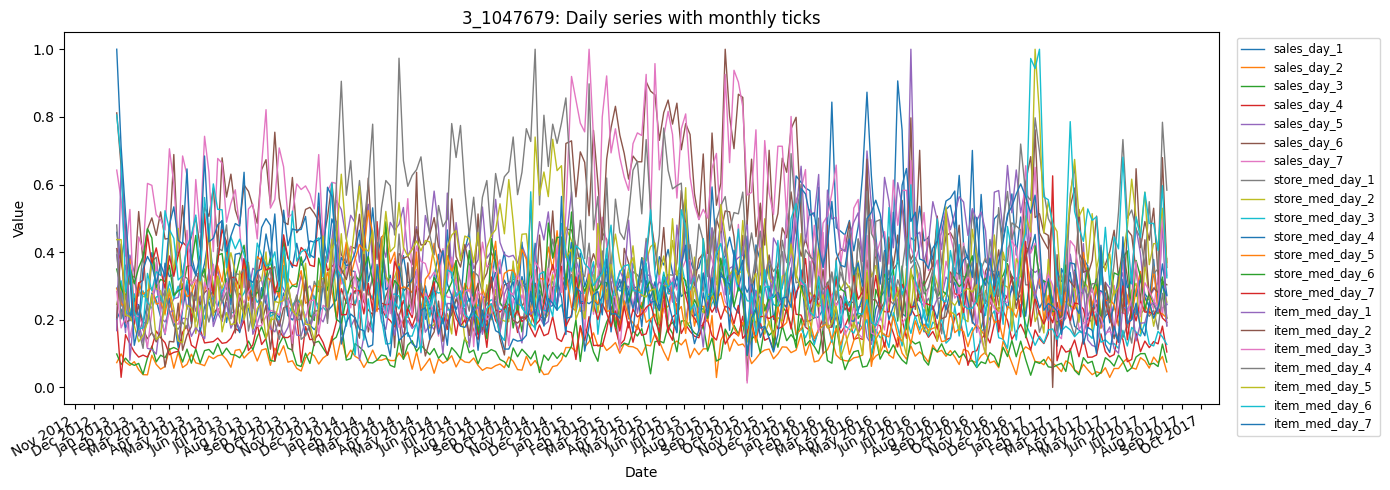

In [56]:

plot_daily_series_with_monthly_ticks(scaled_df, sid="3_1047679")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

def get_splits_for_sid(df, sid, n_splits=5):
    # 1) Filter & sort
    df_sid = df[df["store_item"] == sid].copy()
    df_sid["date"] = pd.to_datetime(df_sid["date"])
    df_sid = df_sid.sort_values("date").reset_index(drop=True)

    # 2) Split & record ranges
    tscv = TimeSeriesSplit(n_splits=n_splits)
    records = []
    dates = df_sid["date"]
    for fold, (train_idx, test_idx) in enumerate(tscv.split(dates), start=1):
        records.append({
            "store_item": sid,
            "fold":       fold,
            "train_start": dates.iloc[train_idx].min(),
            "train_end":   dates.iloc[train_idx].max(),
            "test_start":  dates.iloc[test_idx].min(),
            "test_end":    dates.iloc[test_idx].max(),
        })
    return pd.DataFrame(records), df_sid  # return both for downstream use

def plot_splits(df_sid, n_splits=5):
    # assumes df_sid is the filtered+sorted DataFrame for one sid
    dates = df_sid["date"]
    X = np.arange(len(dates))
    tscv = TimeSeriesSplit(n_splits=n_splits)

    fig, ax = plt.subplots(figsize=(10, 3 + n_splits*0.3))
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        ax.scatter(
            dates.iloc[train_idx],
            [fold]*len(train_idx),
            marker="_", lw=4, alpha=0.6,
            label="train" if fold==1 else None
        )
        ax.scatter(
            dates.iloc[test_idx],
            [fold]*len(test_idx),
            marker="_", lw=4, alpha=0.8,
            label="test" if fold==1 else None
        )

    ax.set_yticks(range(1, n_splits+1))
    ax.set_ylabel("Fold")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    ax.legend(loc="upper right")
    ax.set_title(f"TimeSeriesSplit (n_splits={n_splits}) for store_item = {df_sid['store_item'].iloc[0]}")
    plt.tight_layout()
    plt.show()



ValueError: Cannot have number of folds=6 greater than the number of samples=0.

In [51]:
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
9,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
0,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
1,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
2,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
3,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


  store_item  fold train_start  train_end test_start   test_end
0  3_1047679     1  2013-01-07 2013-11-04 2013-11-11 2014-08-06
1  3_1047679     2  2013-01-07 2014-08-06 2014-08-13 2015-05-08
2  3_1047679     3  2013-01-07 2015-05-08 2015-05-15 2016-02-07
3  3_1047679     4  2013-01-07 2016-02-07 2016-02-14 2016-11-06
4  3_1047679     5  2013-01-07 2016-11-06 2016-11-13 2017-08-08


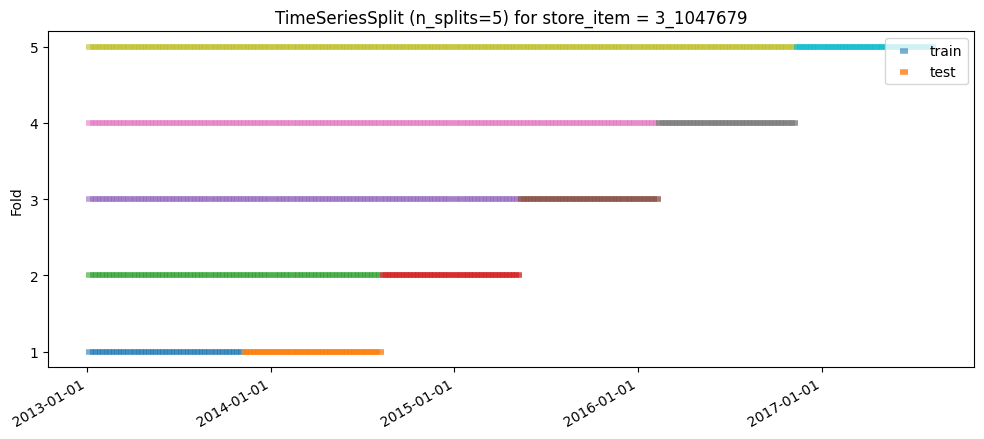

In [52]:

# --- Usage ---
splits_df, df_sid = get_splits_for_sid(df, sid="3_1047679", n_splits=5)
print(splits_df)

# And to visualize:
plot_splits(df_sid, n_splits=5)

In [49]:
splits_df.to_excel("../output/data/scaled_train_timeserieskfold_top_10_store_item.xlsx", index=False)